In [10]:
import base64
import pandas as pd
import requests
import json
import spotipy.util as util
import spotipy
import os
import statistics as st
import math

In [11]:
# import secrets for toke authenification 
import import_ipynb
from spotify_secret import *

importing Jupyter notebook from spotify_secret.ipynb


In [12]:
# secrets
library = cam_library_path
streams = cam_streams_path
username = camUserName

In [18]:
# required information for a authentication token 
scopes = ['user-read-recently-played', 'playlist-modify-private']
# get access toke (tokens only last 1 hour)
token = util.prompt_for_user_token(username=username, scope=scopes, client_id=client_id, client_secret=client_secret, redirect_uri=redirect_uri)
sp = spotipy.Spotify(auth = token)
#header for all api interactions
headers = {'Authorization': 'Bearer ' + token,'Content-Type': 'application/json',}
# boilerplate json for playlist creation
pl_name_data = {'name': '', 'description': 'New playlist description','public': False,}
# URLS
#recent
spotify_url = 'https://api.spotify.com/v1/me/player/recently-played'
#playlist
playlist_url = f'https://api.spotify.com/v1/users/{username}/playlists'

## Functions

#### Get information

In [21]:
# gets track uri and returns a string
def get_uri(df):
    df = df.reset_index(drop=True)
    df['uri'] = ''
    for i in range(0, len(df)):
        search_song = sp.search(q=f'track: {df.loc[i,'trackName']} artist: {df.loc[i,'artistName']}', type='track')
        track_uri = search_song['tracks']['items'][0]['uri']
        df.loc[i,'uri'] = track_uri
    return df

In [22]:
# creates dataframe of song features (numeric data about song qualities)
def get_features_df(df):
    feature_list = []
    track_uris = list(df['uri'])
    chunks = [track_uris[x:x+50] for x in range(0, len(track_uris), 50)]
    for chunk in chunks:
        features = sp.audio_features(chunk)
        feature_list.append(pd.DataFrame.from_records(features))
    df2 = pd.concat(feature_list)
    full_df = df.join(df2.set_index('uri'), on='uri')
    return full_df

#### Playlist Creation and modification

In [36]:
# function to create playlist and return playlist id for modification
def new_playlist(playlist_name):
    pl_name_data['name'] = playlist_name
    playlist_created = requests.post(playlist_url, headers=headers, json=pl_name_data)
    pl_obj = playlist_created.json()
    pl_id = pl_obj['id']
    return pl_obj

In [24]:
# function to update created plalists (only accepts lists of uris < 100)
def mod_playlist(pl_id, pl_uris):
    sp.playlist_add_items(pl_id, pl_uris, position=None)

In [25]:
# make a playlist for each year pressent and add songs in batches 
def yr_playlist(df):
    years = set(list(df['year']))
    for yr in years:
        df_by_year = df[df['year']==yr]
        pl_id = new_playlist(f'Lost Tracks {str(yr)}')
        full_uri_list = list(df_by_year['uri'])
        chunks = [full_uri_list[x:x+50] for x in range(0, len(full_uri_list), 50)]
        for chunk in chunks:
            mod_playlist(pl_id, chunk)

In [26]:
def bad_song_playlist(name, df):
    pl_id = new_playlist(f'{name}: Do You Still Like This')
    full_uri_list = list(df['uri'])
    chunks = [full_uri_list[x:x+50] for x in range(0, len(full_uri_list), 50)]
    for chunk in chunks:
        mod_playlist(pl_id, chunk)

### Recently played

In [31]:
# recent tracks
request = requests.get(url = spotify_url, headers=headers)
recent = request.json()

### The Data 

In [3]:
# df of library library
def library_df(library):
    with open(library+r'\YourLibrary.json', encoding="utf8") as json_data:
        data = json.load(json_data)
    my_library = pd.DataFrame(data['tracks'])
    my_library['art_track'] = my_library['artist'] + my_library['track']
    return my_library

In [4]:
# df of all streams
def streams_df(streams):
    stream_paths = [os.path.join(streams, item) for item in os.listdir(streams)]
    list_of_df = []
    for file in stream_paths:
        with open(file, encoding="utf8") as stream_json:
            stream_data = json.load(stream_json)
            my_streams = pd.DataFrame(stream_data)
            list_of_df.append(my_streams)
    full_streams = pd.concat(list_of_df)
    # ms to seconds to remove skips 
    full_streams['endTime'] = pd.to_datetime(full_streams['endTime'])
    full_streams['msPlayed'] = (full_streams['msPlayed'] / 1000)
    full_streams = full_streams.rename(columns={'msPlayed' : 'Secs_played'})
    full_streams['art_track'] = full_streams['artistName'] + full_streams['trackName']
    return full_streams

#### played alot but not saved

In [5]:
def not_saved_df(my_full_streams, my_library):
    #remove quickly skipped songs
    print(my_full_streams.shape)
    my_full_streams = my_full_streams[my_full_streams['Secs_played'] > 8]
    print(my_full_streams.shape)
    my_full_streams['endTime'] = pd.DatetimeIndex(my_full_streams['endTime']).year
    my_full_streams['count'] = my_full_streams.groupby('art_track')['art_track'].transform('count')
    # the year the track was played the most
    my_full_streams['year'] = my_full_streams.groupby('art_track')['endTime'].transform(lambda x: st.mode(x))
    print(my_full_streams.shape)
    no_skips = my_full_streams[['trackName','artistName', 'art_track', 'year', 'count']]
    no_skips = no_skips.drop_duplicates()
    print(no_skips.shape)
    over_five = no_skips[no_skips['count'] >= 5]
    print(over_five.shape)
    not_liked = over_five[~over_five['art_track'].isin(my_library['art_track'])]
    print(not_liked.shape)
    return not_liked
    

In [29]:
print(len(not_liked[not_liked['year'] == 2022]))
print(len(not_liked[not_liked['year'] == 2023]))

28
25


### Songs That I May Not Like Anymore 

##### skipped

In [6]:
def skipped_df(df, my_library):    
    df = df[df['art_track'].isin(my_library['art_track'])]
    df = df[df['Secs_played'] < 10]
    df['count'] = df.groupby('art_track')['art_track'].transform('count')
    df = df[['trackName','artistName', 'art_track', 'count']]
    df = df.drop_duplicates()
    skipped = df[df['count'] >= 5]
    skipped = skipped.reset_index()

#### not played

In [7]:
# df of songs that are in my library but haven't been listened to in a while 

def not_played_df(no_dup, my_library):
    no_dup = no_dup[['trackName','artistName', 'art_track']]
    no_dup = no_dup.drop_duplicates()
    not_played = my_library[~my_library['art_track'].isin(no_dup['art_track'])]
    return not_played

## make playlist

In [13]:
saved_library = library_df(library)
streamed = streams_df(streams)

In [30]:
#make playlists by year 
not_saved = not_saved_df(streamed, saved_library)
yr_playlist(not_saved)

KeyError: 'id'

In [26]:
# playlist of songs I liked but haven't listened to in a year
not_played = not_played_df(streamed, saved_library)
bad_song_playlist('Not Played', not_played)

In [75]:
# playlist of songs I liked but skip alot
skipped = skipped_df(streamed, saved_library)
bad_song_playlist('Skipped', skipped)

### Feature analysis

In [39]:
no_skips.shape

(3308, 5)

In [49]:
sample1 = no_skips.sample(n=200, random_state=1)
sample2 = no_skips.sample(n=500, random_state=100)

In [ ]:
#############################################

In [50]:
sample1 = sample1.reset_index(drop=True)
sample1['uri'] = ''
for i in range(0, len(sample1)):
    sample1.loc[i,'uri'] = get_uri(sample1.loc[i,'trackName'], sample1.loc[i,'artistName'])


In [51]:
df_feat = get_features(sample1)
full_df = df_feat.join(sample1.set_index('uri'), on='uri')
full_df.sort_values(['count'], ascending=False)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,uri,track_href,analysis_url,duration_ms,time_signature,trackName,artistName,art_track,year,count
2,0.329,0.265,3,-13.619,1,0.0429,0.74800,0.031900,0.1010,0.304,...,spotify:track:3tnfHy341CDlAtcSmUtuOG,https://api.spotify.com/v1/tracks/3tnfHy341CDl...,https://api.spotify.com/v1/audio-analysis/3tnf...,236246,5,I Am the Antichrist to You,Kishi Bashi,Kishi BashiI Am the Antichrist to You,2022,21
30,0.553,0.652,4,-11.625,1,0.0403,0.81000,0.000017,0.1150,0.660,...,spotify:track:38llcrfX1arUqrEe0DRRzW,https://api.spotify.com/v1/tracks/38llcrfX1arU...,https://api.spotify.com/v1/audio-analysis/38ll...,194493,4,I Got a Name - Stereo Version,Jim Croce,Jim CroceI Got a Name - Stereo Version,2023,14
35,0.633,0.529,1,-10.975,0,0.0288,0.14000,0.000519,0.1320,0.642,...,spotify:track:2heBToLEB7odACQ3xwb32A,https://api.spotify.com/v1/tracks/2heBToLEB7od...,https://api.spotify.com/v1/audio-analysis/2heB...,200213,4,Scarecrow In The Garden,Chris Stapleton,Chris StapletonScarecrow In The Garden,2023,13
12,0.636,0.454,5,-16.548,1,0.0615,0.59900,0.003430,0.3040,0.806,...,spotify:track:6IcU0P6Ec5CM9qVqV1U2JH,https://api.spotify.com/v1/tracks/6IcU0P6Ec5CM...,https://api.spotify.com/v1/audio-analysis/6IcU...,200240,4,That's the Way That the World Goes 'Round,John Prine,John PrineThat's the Way That the World Goes '...,2022,13
40,0.567,0.311,2,-14.464,0,0.0455,0.82200,0.230000,0.1100,0.478,...,spotify:track:3Ozx6IrGdoQyAworJzvBDE,https://api.spotify.com/v1/tracks/3Ozx6IrGdoQy...,https://api.spotify.com/v1/audio-analysis/3Ozx...,192480,4,Sleeping on the Blacktop,Colter Wall,Colter WallSleeping on the Blacktop,2022,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,0.267,0.956,5,-2.987,0,0.0683,0.00110,0.001900,0.0716,0.870,...,spotify:track:4P1ypKiVXhfFMbcEmtQ0Js,https://api.spotify.com/v1/tracks/4P1ypKiVXhfF...,https://api.spotify.com/v1/audio-analysis/4P1y...,152987,4,The United States of Cryptids: A Conversation ...,Last Podcast On The Left,Last Podcast On The LeftThe United States of C...,2022,1
29,0.336,0.620,0,-9.976,1,0.0406,0.02930,0.000000,0.1240,0.283,...,spotify:track:2E6elGQS3KaKR7QdfzQXdP,https://api.spotify.com/v1/tracks/2E6elGQS3KaK...,https://api.spotify.com/v1/audio-analysis/2E6e...,294800,4,Big Empty - 2019 Remaster,Stone Temple Pilots,Stone Temple PilotsBig Empty - 2019 Remaster,2022,1
31,0.331,0.659,7,-10.640,1,0.0795,0.00352,0.000027,0.0820,0.177,...,spotify:track:2HRYa6iG1M5DRefO8pK2I3,https://api.spotify.com/v1/tracks/2HRYa6iG1M5D...,https://api.spotify.com/v1/audio-analysis/2HRY...,249973,4,Reagan,Killer Mike,Killer MikeReagan,2022,1
35,0.619,0.850,1,-7.094,0,0.0363,0.00261,0.031600,0.1260,0.789,...,spotify:track:4oxA1ZfTm2QtRj09cBX5SA,https://api.spotify.com/v1/tracks/4oxA1ZfTm2Qt...,https://api.spotify.com/v1/audio-analysis/4oxA...,166120,4,Bambi,Tokyo Police Club,Tokyo Police ClubBambi,2023,1


In [57]:
full_df.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'trackName', 'artistName', 'art_track', 'year',
       'count'],
      dtype='object')

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols

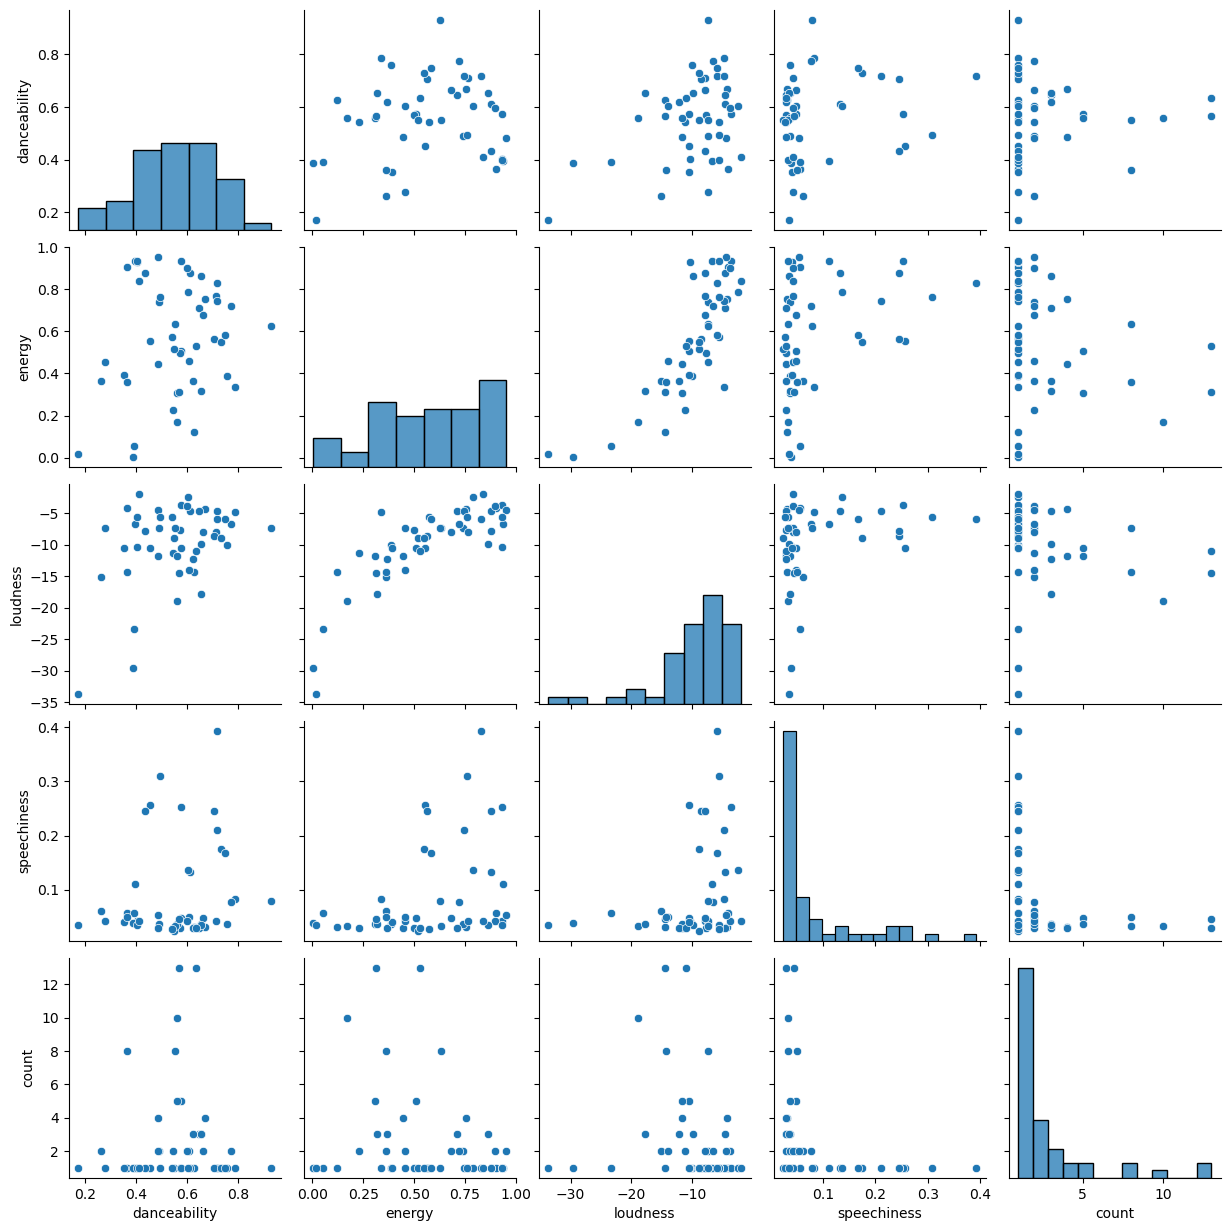

In [63]:
less_cols1 = full_df[['danceability', 'energy', 'loudness', 'speechiness', 'uri', 'count']]
less_cols2 = full_df[['acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'uri', 'count']]
sns.pairplot(less_cols1)
plt.show()

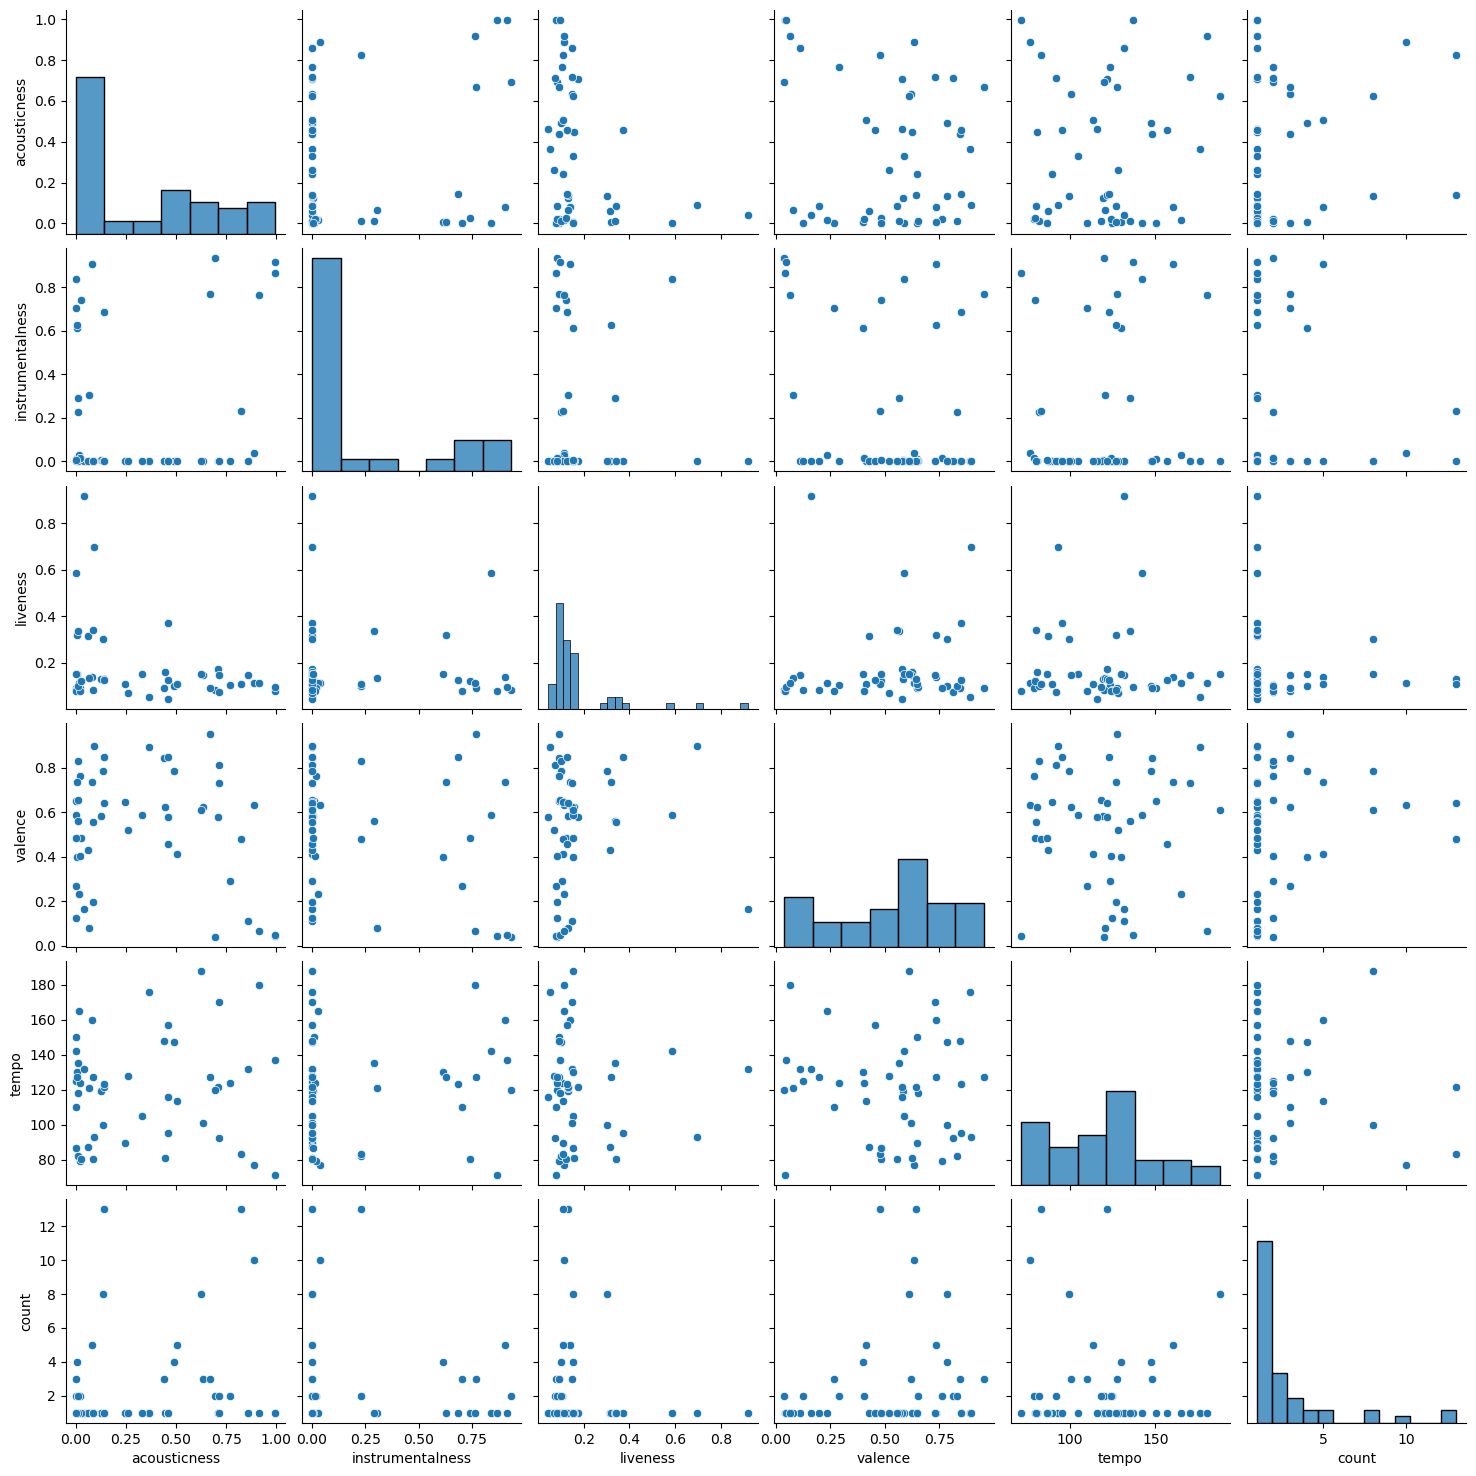

In [64]:
sns.pairplot(less_cols2)
plt.show()

In [65]:
ols_formula = 'count ~ acousticness + valence + tempo'
OLS = ols(formula = ols_formula, data = full_df)
model = OLS.fit()
results = model.summary()
results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.277
Date:                Thu, 15 Jun 2023   Prob (F-statistic):              0.294
Time:                        10:46:00   Log-Likelihood:                -122.30
No. Observations:                  50   AIC:                             252.6
Df Residuals:                      46   BIC:                             260.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.6299      2.053      0.794      0.431      -2.503       5.762
acousticness     2.0001      1.286      1.555      0.127      -0.589       4.589
valence          2.1491      1.626      1.322      0.193      -1.123       5.421
tempo           -0.0074      0.014     -0.522      0.604      -0.036       0.021
==============================================================================
Omnibus:                       36.448   Durbin-Watson:                   2.353
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.301
Skew:                           2.183   Prob(JB):                     4.95e-19
Kurtosis:                       7.626   Cond. No.                         700.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""